In [1]:
import pandas, seaborn, scipy, numpy, matplotlib, sklearn, collections, itertools, math, functools, sys

import stanity

%matplotlib inline
from matplotlib import pyplot
matplotlib.rc("savefig", dpi=800)
#matplotlib.rc("savefig", dpi=72)

from sklearn import preprocessing

# Constants
library_sizes = {
    'WGS': 3002000000,
    'WES': 50160183,
}
mhc_binding_threshold_affinity = 500

def bootstrap(values, statistic=numpy.mean, samples=5000):
    values = pandas.Series(values).dropna()
    if len(values) <= 1:
        return (numpy.nan, numpy.nan)
    values = [statistic(sklearn.utils.resample(values)) for i in range(samples)]
    return (numpy.percentile(values, 5), numpy.percentile(values, 95))

def round_to_n(x, n):
    return round(x, -int(math.floor(math.log10(x))) + (n - 1)) 

def mean_with_errorbars(values, decimals=0):
    pattern = "%%0.%df" % decimals
    bars = bootstrap(values)
    if numpy.nan in bars:
        return pattern % numpy.mean(values)
    if decimals == 0:
        bars = (round_to_n(bars[0], 2), round_to_n(bars[1], 2)) 
    return (pattern + " (" + pattern + " - " + pattern + ")") % ((numpy.mean(values),) + bars)

pandas.set_option('display.max_columns', 500)


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df = pandas.read_csv("../data/sources.extended.csv", index_col="source_id")
df = df.ix[~pandas.isnull(df.mutations)]
df.head()

,Unnamed: 0,index,donor,cohort,library,treated,timepoint,metastasis,tissue_type,interval_days,assay,paired,timepoint_paired,protein changing,peptides,expressed peptides,mutations,mutations_per_mb,indel,interesting mutations,group,treatment,fraction_peptides_expressed,project_code,study_specimen_involved_in,submitted_specimen_id,icgc_donor_id,submitted_donor_id,specimen_type,specimen_type_other,specimen_interval,specimen_donor_treatment_type,specimen_donor_treatment_type_other,specimen_processing,specimen_storage,tumour_confirmed,tumour_histological_type,tumour_grading_system,tumour_grade,tumour_stage_system,tumour_stage,percentage_cellularity,level_of_cellularity
source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AOCS-001-1/SP101515,0,SP101515,AOCS-001,AOCS,WGS,False,primary,False,solid,0.0,WGS,False,False,50,128,71.0,5937,1.977682,1.0,19.302678,AOCS solid,treatment naive,0.554688,OV-AU,PCAWG,AOCS-001-1,DO46325,AOCS-001,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3.0,FIGO,III,73.0,61-80%
AOCS-002-1/SP101517,1,SP101517,AOCS-002,AOCS,WGS,False,primary,False,solid,0.0,WGS,False,False,11,32,NaN,1532,0.510326,0.0,17.297650,AOCS solid,treatment naive,NaN,OV-AU,PCAWG,AOCS-002-1,DO46326,AOCS-002,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,2.0,FIGO,III,85.0,>81%
AOCS-004-1/SP101519,2,SP101519,AOCS-004,AOCS,WGS,False,primary,False,solid,0.0,WGS,False,False,57,58,20.0,6786,2.260493,1.0,16.931919,AOCS solid,treatment naive,0.344828,OV-AU,PCAWG,AOCS-004-1,DO46327,AOCS-004,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3.0,FIGO,III,77.0,61-80%
AOCS-005-1/SP101521,3,SP101521,AOCS-005,AOCS,WGS,False,primary,False,solid,0.0,WGS,False,False,39,61,39.0,5703,1.899734,2.0,15.640891,AOCS solid,treatment naive,0.639344,OV-AU,PCAWG,AOCS-005-1,DO46328,AOCS-005,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3.0,FIGO,III,90.0,>81%
AOCS-034-13/SP101524,4,SP101524,AOCS-034,AOCS,WGS,True,recurrence,False,ascites,1597.0,WGS,True,True,123,267,136.0,13626,4.538974,5.0,17.906943,AOCS ascites,chemo treated,0.509363,OV-AU,NaN,AOCS-034-13,DO46329,AOCS-034,Recurrent tumour - other,recurrent ascitic fluid,1597,other therapy,Surgery and Chemotherapy,fresh,"frozen, vapor phase",no,8140/3,NaN,NaN,NaN,NaN,99.0,>81%


In [3]:
predicted = ["mutations", "peptides", "expressed peptides"]

# donor is handled specially
predictors = [
    "treated",
#    "timepoint",
#    "metastasis",
#    "specimen_interval",
    "tissue_type",
#    "tumour_grade",
#    "tumour_stage",
    "percentage_cellularity"
]

## model1 original bayesian analysis

In [4]:
def make_data(y_column):
    stan_df = df[[y_column, "donor"] + predictors].copy()
    stan_df.columns = ["y"] + list(stan_df.columns[1:])
    stan_df["y"] = numpy.log(stan_df["y"])
    original_donors = stan_df.donor
    stan_df["low_cellularity"] = stan_df.percentage_cellularity < stan_df.dropna().percentage_cellularity.quantile(.25)
    del stan_df["percentage_cellularity"]
    stan_df["solid"] = stan_df["tissue_type"] == "solid"
    del stan_df["tissue_type"]
    stan_df["num_sources_for_donor"] = pandas.Series(
        [(original_donors == donor).sum() for donor in original_donors],
        index=original_donors.index)

    stan_df = stan_df.dropna()
    stan_df["donor"] = stan_df.donor.astype('category').values.codes
    stan_df["solid and treated"] = (stan_df.solid) & (stan_df.treated)
    return stan_df

data_by_predicted = collections.OrderedDict()
for col in predicted:
    data_by_predicted[col] = make_data(col)
    print(col, data_by_predicted[col].shape)
data_by_predicted["mutations"].head()  

('mutations', (115, 7))
('peptides', (115, 7))
('expressed peptides', (98, 7))


,y,donor,treated,low_cellularity,solid,num_sources_for_donor,solid and treated
source_id,,,,,,,
AOCS-001-1/SP101515,8.688959,0,False,True,True,1,False
AOCS-002-1/SP101517,7.334329,1,False,False,True,1,False
AOCS-004-1/SP101519,8.822617,2,False,True,True,1,False
AOCS-005-1/SP101521,8.648748,3,False,False,True,1,False
AOCS-034-13/SP101524,9.519735,4,True,False,False,2,False


In [5]:
# stan model
model1 = """
data {
    // Data sizes
    int<lower=0> num_sources;
    int<lower=0> num_predictors;
    int<lower=0> num_donors;

    // Data
    vector[num_predictors] predictors[num_sources];
    int<lower=0> donors[num_sources];
    real y[num_sources];  // predicted variable
    int<lower=1> num_sources_for_donor[num_sources];
}
parameters {
    real global_mean;
    real<lower=0> donor_sigma;
    real<lower=0> sample_sigma;
    vector[num_donors] donor_mean;    
    vector[num_predictors] predictor_coefficients;
}
transformed parameters {
    real lp;
    real mu[num_sources];
    
    for (i in 1:num_sources) {
        lp <- dot_product(predictors[i], predictor_coefficients);
        if (num_sources_for_donor[i] > 1) {
            mu[i] <- donor_mean[donors[i]] + lp;
        } else {
            mu[i] <- global_mean + lp;
        }
    }
}
model {
    global_mean ~ normal(0, 100);
    donor_sigma ~ cauchy(0, 2);
    sample_sigma ~ cauchy(0, 2);
    donor_mean ~ normal(global_mean, donor_sigma);
    predictor_coefficients ~ normal(0, 20);
    y ~ normal(mu, sample_sigma);    
}
generated quantities {
    real y_rep[num_sources];
    real log_lik[num_sources];
    
    for (i in 1:num_sources) {
        // not sure if these are vectorized
        y_rep[i] <- normal_rng(mu[i], sample_sigma);
        log_lik[i] <- normal_log(y[i], mu[i], sample_sigma);
    }
}
""".strip()

data = {    

}
def init(data):
    return {
        'global_mean': 0.0,
        'donor_sigma': 1.0,
        'sample_sigma': 1.0,
        'donor_mean': numpy.zeros(data['num_donors']),
        'predictor_coefficients': numpy.random.normal(0, .1, size=(data['num_predictors'],)),
    }

for (i, line) in enumerate(model1.split("\n")):
    print("%3d %s" % (i + 1, line))

def print_dict(d):
    for key in [key for key in d if not isinstance(d[key], numpy.ndarray)]:
        print("%s: %s" % (key, d[key]))
    for key in [key for key in d if isinstance(d[key], numpy.ndarray)]:
        print("%s: %s mean=%s std=%s" % (key,  d[key].shape, d[key].mean(), d[key].std()))

fit_results = {}
for (y_label, raw_data) in data_by_predicted.items():
    print("+" * 40)
    print("RUNNING MODEL FOR: %s" % y_label)
    df_x = raw_data[[x for x in list(raw_data.columns) if x not in ("y", "donor")]].astype(float)
    data = {
        'num_sources': len(raw_data.index),
        'num_predictors': len(df_x.columns),
        'num_donors': raw_data.donor.nunique(),

        'predictors': df_x.values.astype(float),
        'donors': raw_data.donor.values + 1,  # convert to 1-indexed
        'num_sources_for_donor': raw_data.num_sources_for_donor.values,
        'y': raw_data.y.values,
    }
    print("")
    print("*" * 40)
    print("DATA")
    print_dict(data)
    print("")

    print("*" * 40)
    print("INITIAL VALUES")
    print_dict(init(data))
    sys.stdout.flush()
    
    fit_results[y_label] = stanity.fit(model_code=model1, data=data, init=lambda: init(data), iter=10000, chains=2)
    print("Done with fit.")
print("DONE")


  1 data {
  2     // Data sizes
  3     int<lower=0> num_sources;
  4     int<lower=0> num_predictors;
  5     int<lower=0> num_donors;
  6 
  7     // Data
  8     vector[num_predictors] predictors[num_sources];
  9     int<lower=0> donors[num_sources];
 10     real y[num_sources];  // predicted variable
 11     int<lower=1> num_sources_for_donor[num_sources];
 12 }
 13 parameters {
 14     real global_mean;
 15     real<lower=0> donor_sigma;
 16     real<lower=0> sample_sigma;
 17     vector[num_donors] donor_mean;    
 18     vector[num_predictors] predictor_coefficients;
 19 }
 20 transformed parameters {
 21     real lp;
 22     real mu[num_sources];
 23     
 24     for (i in 1:num_sources) {
 25         lp <- dot_product(predictors[i], predictor_coefficients);
 26         if (num_sources_for_donor[i] > 1) {
 27             mu[i] <- donor_mean[donors[i]] + lp;
 28         } else {
 29             mu[i] <- global_mean + lp;
 30         }
 31     }
 32 }
 33 model {
 34     global

In [6]:
## here, compare two models - first having uniform variance, second where variance depends on source type
loosummary1 = stanity.psisloo(log_lik=fit_results['mutations'].extract()['log_lik'])


/usr/local/lib/python2.7/dist-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/usr/local/lib/python2.7/dist-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]


In [7]:
loosummary1.print_summary()

greater than 0.5    0.0
greater than 1      0.0
dtype: float64

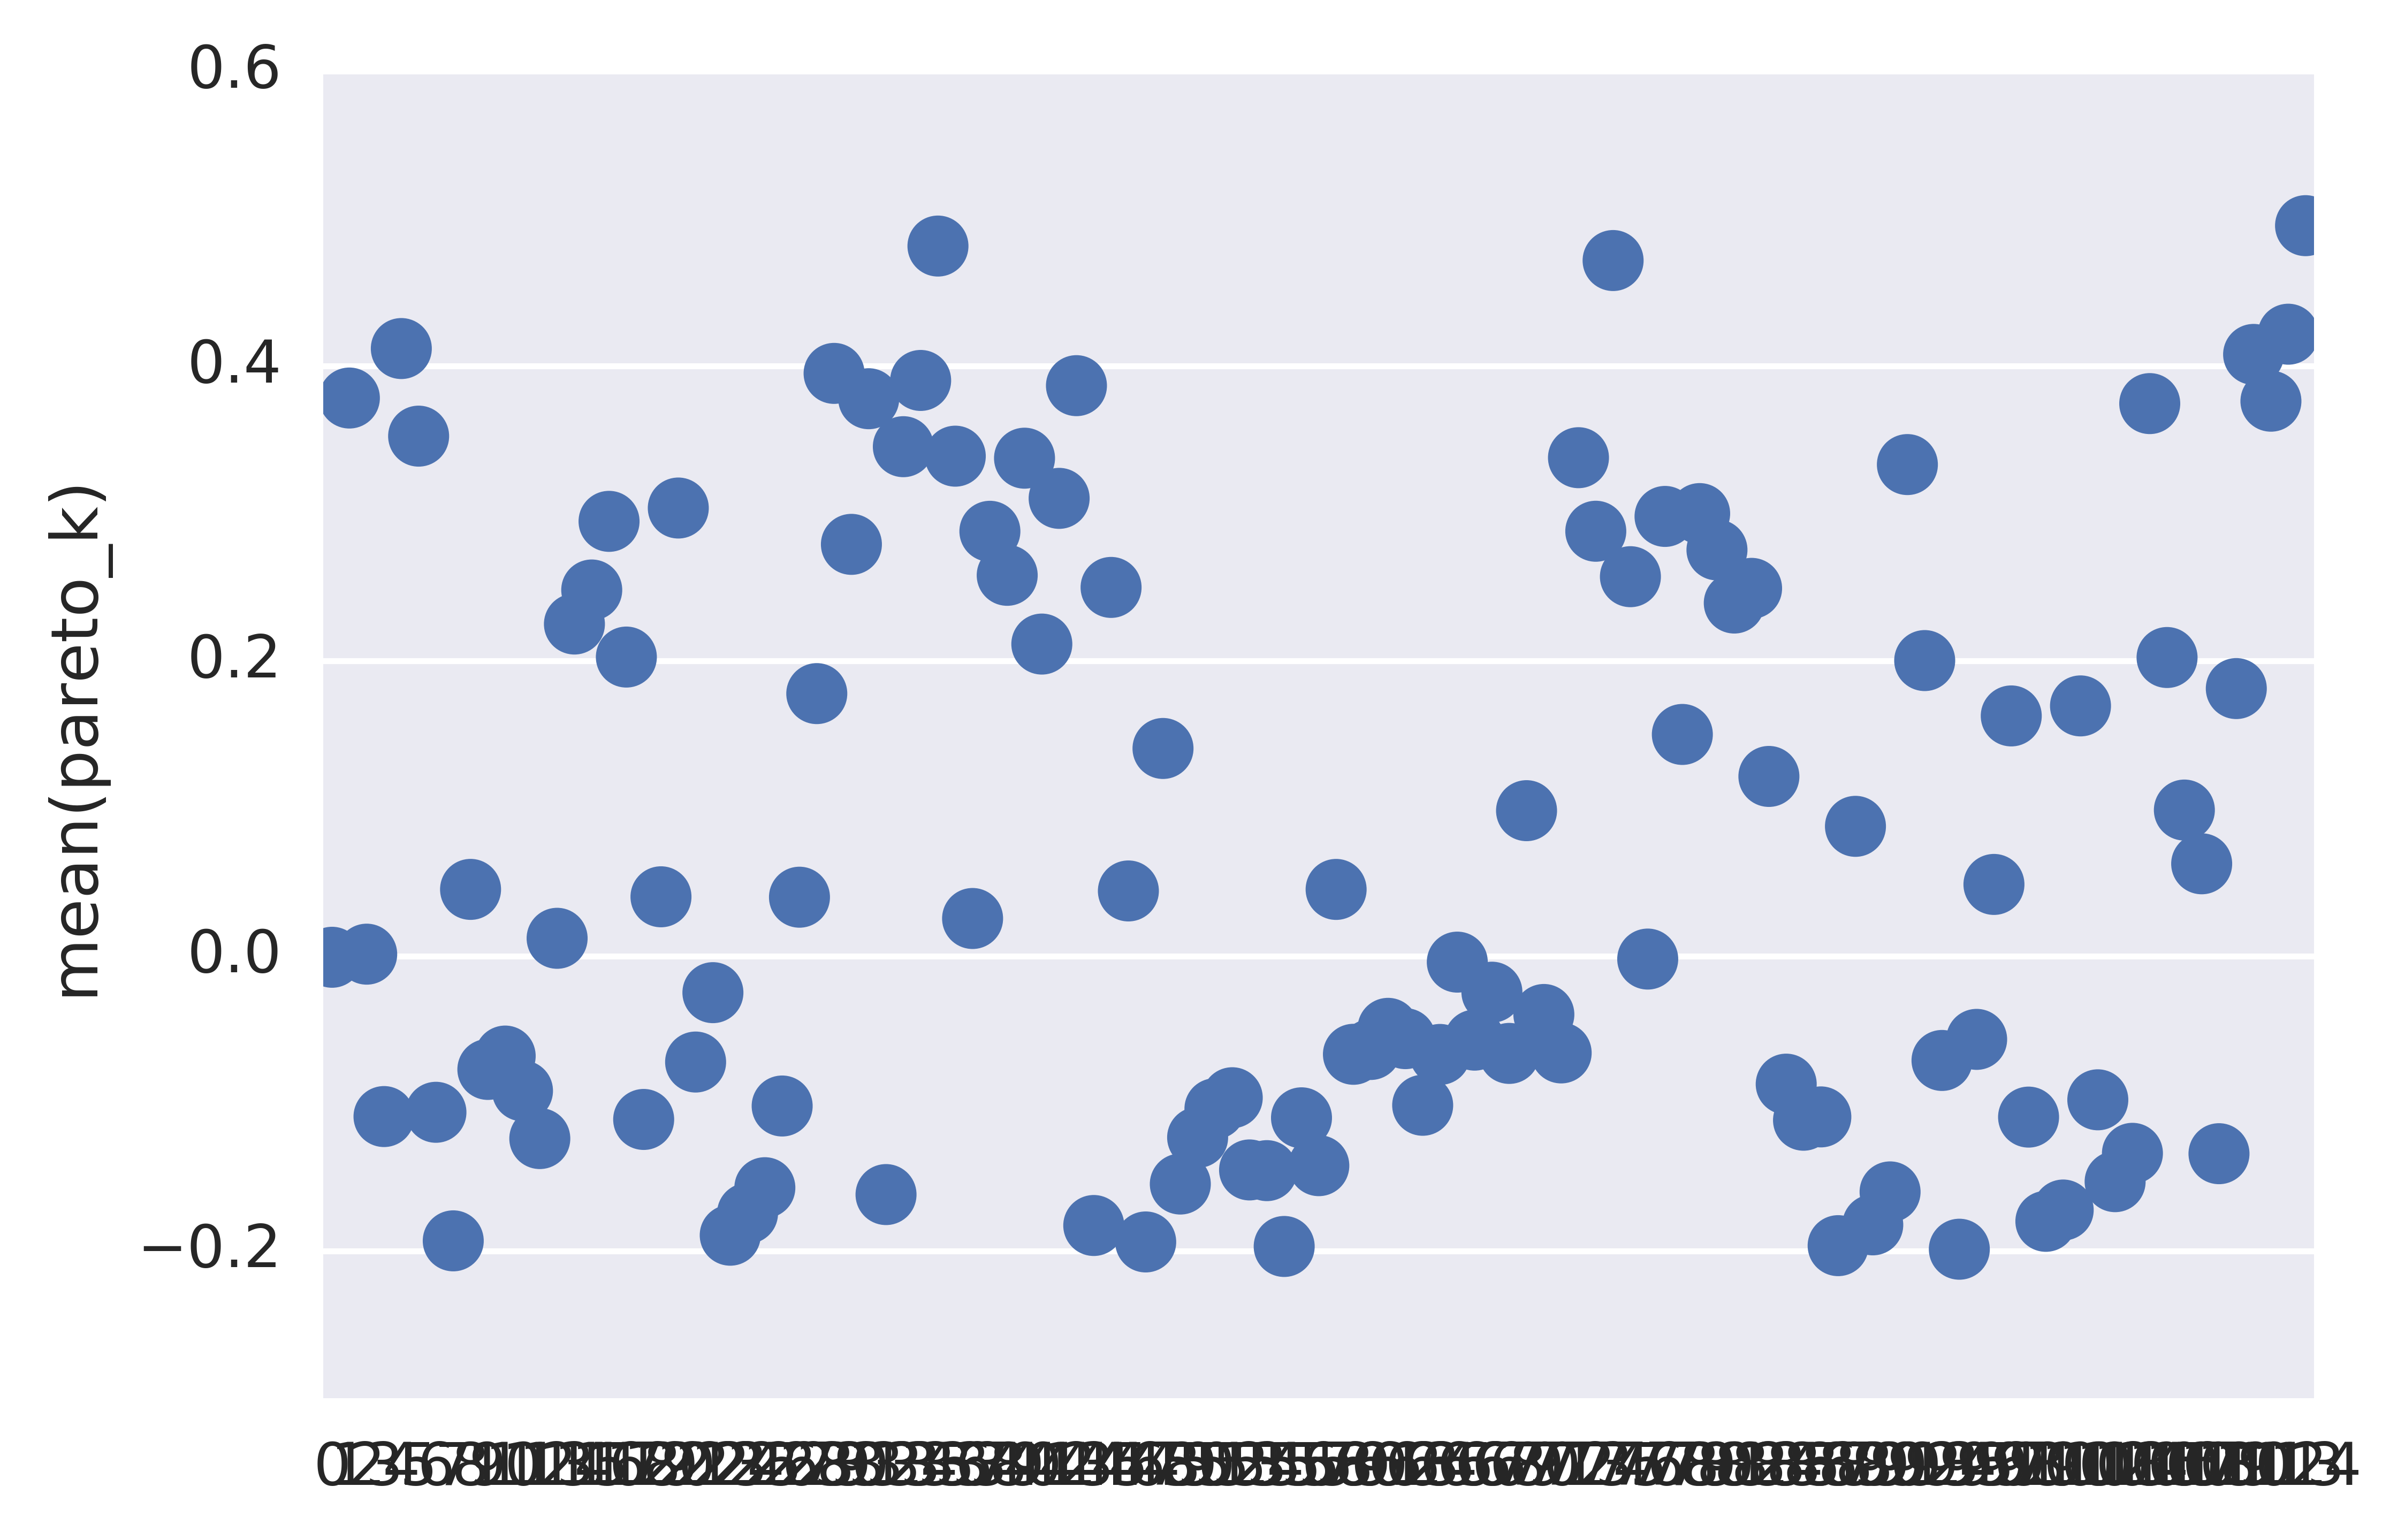

In [8]:
loosummary1.plot()

## model2 separating recurrence timepoint from primary

In [9]:
predicted2 = ["mutations", "peptides", "expressed peptides"]

# donor is handled specially
predictors2 = [
    "treated",
    "timepoint",
#    "metastasis",
#    "specimen_interval",
    "tissue_type",
#    "tumour_grade",
#    "tumour_stage",
    "percentage_cellularity"
]

def make_data2(y_column):
    stan_df = df[[y_column, "donor"] + predictors2].copy()
    stan_df.columns = ["y"] + list(stan_df.columns[1:])
    stan_df["y"] = numpy.log(stan_df["y"])
    original_donors = stan_df.donor
    stan_df["low_cellularity"] = stan_df.percentage_cellularity < stan_df.dropna().percentage_cellularity.quantile(.25)
    del stan_df["percentage_cellularity"]
    stan_df["recurrence"] = stan_df["timepoint"] == "recurrence"
    del stan_df["timepoint"]

    stan_df["ascites"] = stan_df["tissue_type"] == "ascites"
    del stan_df["tissue_type"]
    
    stan_df["num_sources_for_donor"] = pandas.Series(
        [(original_donors == donor).sum() for donor in original_donors],
        index=original_donors.index)

    stan_df = stan_df.dropna()
    stan_df["donor"] = stan_df.donor.astype('category').values.codes
    #stan_df["solid and treated"] = (~stan_df.ascites) & (stan_df.treated)
    return stan_df

data_by_predicted2 = collections.OrderedDict()
for col in predicted2:
    data_by_predicted2[col] = make_data2(col)
    print(col, data_by_predicted2[col].shape)
data_by_predicted2["mutations"].head()

('mutations', (115, 7))
('peptides', (115, 7))
('expressed peptides', (98, 7))


,y,donor,treated,low_cellularity,recurrence,ascites,num_sources_for_donor
source_id,,,,,,,
AOCS-001-1/SP101515,8.688959,0,False,True,False,False,1
AOCS-002-1/SP101517,7.334329,1,False,False,False,False,1
AOCS-004-1/SP101519,8.822617,2,False,True,False,False,1
AOCS-005-1/SP101521,8.648748,3,False,False,False,False,1
AOCS-034-13/SP101524,9.519735,4,True,False,True,True,2


In [10]:
# stan model
model2 = model1

data = {    

}
def init(data):
    return {
        'global_mean': 0.0,
        'donor_sigma': 1.0,
        'sample_sigma': 1.0,
        'donor_mean': numpy.zeros(data['num_donors']),
        'predictor_coefficients': numpy.random.normal(0, .1, size=(data['num_predictors'],)),
    }

for (i, line) in enumerate(model2.split("\n")):
    print("%3d %s" % (i + 1, line))

fit_results2 = {}
for (y_label, raw_data) in data_by_predicted2.items():
    print("+" * 40)
    print("RUNNING MODEL FOR: %s" % y_label)
    df_x = raw_data[[x for x in list(raw_data.columns) if x not in ("y", "donor")]].astype(float)
    data = {
        'num_sources': len(raw_data.index),
        'num_predictors': len(df_x.columns),
        'num_donors': raw_data.donor.nunique(),

        'predictors': df_x.values.astype(float),
        'donors': raw_data.donor.values + 1,  # convert to 1-indexed
        'num_sources_for_donor': raw_data.num_sources_for_donor.values,
        'y': raw_data.y.values,
    }
    print("")
    print("*" * 40)
    print("DATA")
    print_dict(data)
    print("")

    print("*" * 40)
    print("INITIAL VALUES")
    print_dict(init(data))
    sys.stdout.flush()
    
    fit_results2[y_label] = stanity.fit(model_code=model2, data=data, init=lambda: init(data), iter=10000, chains=2)
    print("Done with fit.")
print("DONE")


  1 data {
  2     // Data sizes
  3     int<lower=0> num_sources;
  4     int<lower=0> num_predictors;
  5     int<lower=0> num_donors;
  6 
  7     // Data
  8     vector[num_predictors] predictors[num_sources];
  9     int<lower=0> donors[num_sources];
 10     real y[num_sources];  // predicted variable
 11     int<lower=1> num_sources_for_donor[num_sources];
 12 }
 13 parameters {
 14     real global_mean;
 15     real<lower=0> donor_sigma;
 16     real<lower=0> sample_sigma;
 17     vector[num_donors] donor_mean;    
 18     vector[num_predictors] predictor_coefficients;
 19 }
 20 transformed parameters {
 21     real lp;
 22     real mu[num_sources];
 23     
 24     for (i in 1:num_sources) {
 25         lp <- dot_product(predictors[i], predictor_coefficients);
 26         if (num_sources_for_donor[i] > 1) {
 27             mu[i] <- donor_mean[donors[i]] + lp;
 28         } else {
 29             mu[i] <- global_mean + lp;
 30         }
 31     }
 32 }
 33 model {
 34     global

In [11]:
loosummary2 = stanity.psisloo(log_lik=fit_results2['mutations'].extract()['log_lik'])


In [12]:
loosummary2.print_summary()

greater than 0.5    0.017391
greater than 1      0.000000
dtype: float64

## compare model1 to model2

In [13]:
stanity.loo_compare(loosummary1, loosummary2)

{'diff': 1.0595483300420074, 'se_diff': 1.0439730850286311}